In [1]:
# %matplotlib notebook

In [2]:
import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import os
import datetime
import optuna
import json

import matplotlib.pyplot as plt
from IPython.display import display, clear_output, update_display

import stockanalibs

pd.set_option('display.max_columns', None)


In [3]:
ticker = "TSLA"
source_folder = "Intraday stocks" 
results_folder = "optuna results"              

n_trials = 100

pattern = os.path.join(source_folder, f"{ticker}_*.csv")
files = glob.glob(pattern)

if not files:
    raise FileNotFoundError(f"No files found for ticker {ticker} in {source_folder}")

# If there are multiple files, you might sort them or choose the first one.
files.sort()  # sorts alphabetically
file_to_read = files[0]

df = pd.read_csv(file_to_read, index_col=0, parse_dates=["datetime"])
df = df[['open', 'high', 'low', 'close', 'volume']]

ask_bid_spread = 0.03 # percent
spread_fraction = ask_bid_spread / 100.0
# Create 'ask' as close price plus the spread fraction and 'bid' as close price minus the spread fraction.
df['ask'] = round(df['close'] * (1 + spread_fraction),4)
df['bid'] = round(df['close'] * (1 - spread_fraction),4)
df

,open,high,low,close,volume,ask,bid
datetime,,,,,,,
2025-01-02 09:00:00,408.00,411.97,406.10,411.840,42018,411.9636,411.7164
2025-01-02 09:01:00,411.86,412.46,411.20,412.070,41642,412.1936,411.9464
2025-01-02 09:02:00,412.18,412.18,409.50,409.890,36889,410.0130,409.7670
2025-01-02 09:03:00,409.89,410.00,407.90,408.350,30469,408.4725,408.2275
2025-01-02 09:04:00,408.31,410.31,408.31,409.450,22542,409.5728,409.3272
...,...,...,...,...,...,...,...
2025-06-03 23:55:00,344.42,344.47,344.30,344.370,3661,344.4733,344.2667
2025-06-03 23:56:00,344.40,344.45,344.33,344.380,2907,344.4833,344.2767
2025-06-03 23:57:00,344.40,344.50,344.35,344.375,5134,344.4783,344.2717


In [4]:
def optimiz_function(df,
                     min_prof_thr,       # percent of minimum profit to define a potential trade
                     max_down_prop,      # float (percent/100) of maximum allowed drop of a potential trade
                     smooth_win_sig,      # smoothing window of the signal used for the identification of the final trades 
                     pre_entry_decay,    # pre-trade decay of the final trades' smoothed signal
                     buy_threshold,     # float (percent/100) threshold of the smoothed signal to trigger the final trade
                     trailing_stop_thresh  # percent of the trailing stop loss of the final trade
                     ):
    
    # First, adjust the input DataFrame's timestamps.
    df = stockanalibs.smooth_prepost_trading_data(df=df, 
                                                  regular_start=stockanalibs.regular_start, 
                                                  regular_end=stockanalibs.regular_end)

    # Identify potential trades day-by-day.
    results_by_day = stockanalibs.identify_trades_daily(df=df,
                                                       min_prof_thr=min_prof_thr, 
                                                       max_down_prop=max_down_prop,
                                                       regular_start_shifted=stockanalibs.regular_start_shifted,
                                                       regular_end=stockanalibs.regular_end)

    # Add trade signals to the daily results (using the unshifted regular_start).
    results_by_day = stockanalibs.add_trade_signal_to_results(results_by_day=results_by_day, 
                                                             min_prof_thr=min_prof_thr, 
                                                             regular_start=stockanalibs.regular_start,
                                                             smooth_win_sig=smooth_win_sig, 
                                                             pre_entry_decay=pre_entry_decay,
                                                             buy_threshold=buy_threshold, 
                                                             trailing_stop_thresh=trailing_stop_thresh)

    # Simulate trading across the days.
    results_by_day = stockanalibs.simulate_trading(results_by_day=results_by_day, 
                                                  regular_start=stockanalibs.regular_start, 
                                                  regular_end=stockanalibs.regular_end,
                                                  ticker=ticker)
    
    # Build a dictionary mapping each day to its strategy improvement.
    improvements = {}
    for day_key, day_result in results_by_day.items():
        improvements[day_key.strftime('%Y-%m-%d')] = day_result[2]['Strategy Improvement (%)']

    avg_improvement = sum(improvements.values()) / len(improvements) 

    # Return the average improvement and the dictionary with day-specific improvements.
    return avg_improvement, improvements


In [5]:

# === Objective Function ===
def objective(trial):
    # Suggest parameters to test.
    params = {
        "min_prof_thr": trial.suggest_float("min_prof_thr", 0.1, 0.5),
        "max_down_prop": trial.suggest_float("max_down_prop", 0.1, 0.5),
        "smooth_win_sig": trial.suggest_int("smooth_win_sig", 3, 30),
        "pre_entry_decay": trial.suggest_float("pre_entry_decay", 0.5, 1.0),
        "buy_threshold": trial.suggest_float("buy_threshold", 0.05, 0.5),
        "trailing_stop_thresh": trial.suggest_float("trailing_stop_thresh", 0.1, 0.5),
    }

    # Run your strategy simulation with the current set of parameters.
    avg_improvement, improvements_dict = optimiz_function(
        df=df,
        min_prof_thr=params["min_prof_thr"],
        max_down_prop=params["max_down_prop"],
        smooth_win_sig=params["smooth_win_sig"],
        pre_entry_decay=params["pre_entry_decay"],
        buy_threshold=params["buy_threshold"],
        trailing_stop_thresh=params["trailing_stop_thresh"]
    )
    
    return avg_improvement



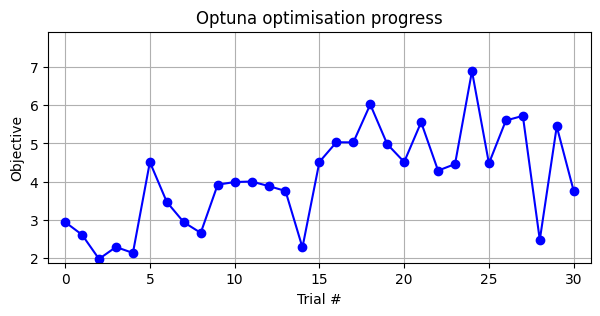

In [6]:
# ----------------------------------------------------------
# create ONE figure
# ----------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 3))
line,   = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Objective",
       title="Optuna optimisation progress", xlim=(0, 1), ylim=(0, 1))
ax.grid(True)

handle = display(fig, display_id=True)   # show once and keep handle
plt.close(fig)                           # <── prevents the duplicate static copy

# ----------------------------------------------------------
# callback
# ----------------------------------------------------------
def live_plot_callback(study, trial):
    xs = [t.number   for t in study.trials]
    ys = [t.value    for t in study.trials]

    line.set_data(xs, ys)
    ax.set_xlim(-1, len(xs))
    ax.set_ylim(min(ys) * 0.95, max(ys) * 1.15)

    update_display(fig, display_id=handle.display_id)   # refresh only this figure




In [ ]:
# === Create and Run the Study ===
study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=n_trials, callbacks=[live_plot_callback])

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)


# ------------------------------------------------------------------
# Build a dynamic file-name:  <results_folder>/<TICKER>_<YYYYMMDD>-<YYYYMMDD>_optuna.json
# ------------------------------------------------------------------

start_date  = df.index.min().strftime("%Y%m%d")  # ❹ first date in the DataFrame
end_date    = df.index.max().strftime("%Y%m%d")  # ❺ last  date in the DataFrame

file_name = f"{ticker}_{start_date}-{end_date}_optuna_results.json"
file_path = os.path.join(results_folder, file_name)

# ------------------------------------------------------------------
# Dump study results
# ------------------------------------------------------------------
with open(file_path, "w") as f:
    json.dump(
        {
            "best_params": study.best_params,
            "best_value": study.best_value,
            "trials": [trial.user_attrs for trial in study.trials],
        },
        f,
        indent=4,)

print(f"Optuna results saved to: {file_path}")


[I 2025-06-11 18:47:47,064] A new study created in memory with name: no-name-6fc70749-f731-4f32-880f-a6e849cfa28c
[I 2025-06-11 18:48:38,790] Trial 0 finished with value: 2.937300970873785 and parameters: {'min_prof_thr': 0.44493334135355167, 'max_down_prop': 0.15998834688621147, 'smooth_win_sig': 5, 'pre_entry_decay': 0.734100339254844, 'buy_threshold': 0.36173499094985057, 'trailing_stop_thresh': 0.3556904810277214}. Best is trial 0 with value: 2.937300970873785.
[I 2025-06-11 18:49:41,618] Trial 1 finished with value: 2.6041844660194173 and parameters: {'min_prof_thr': 0.22785730274246785, 'max_down_prop': 0.4939159932267221, 'smooth_win_sig': 16, 'pre_entry_decay': 0.6120586040240079, 'buy_threshold': 0.4420995062781131, 'trailing_stop_thresh': 0.1782132279157853}. Best is trial 0 with value: 2.937300970873785.
[I 2025-06-11 18:50:30,217] Trial 2 finished with value: 1.9694077669902914 and parameters: {'min_prof_thr': 0.4496633977383043, 'max_down_prop': 0.16878467390720475, 'smoot

In [ ]:
min_prof_thr, max_down_prop, smooth_win_sig, pre_entry_decay, buy_threshold, trailing_stop_thresh = stockanalibs.signal_parameters(ticker)


avg_improvement, improvements = optimiz_function(df=df,
                                                min_prof_thr=min_prof_thr, # percent of minimum profit to define a potential trade
                                                max_down_prop=max_down_prop, # float (percent/100) of maximum allowed drop of a potential trade
                                                smooth_win_sig=smooth_win_sig, # smoothing window of the signal used for the identification of the final trades 
                                                pre_entry_decay=pre_entry_decay, # pre-trade decay of the final trades' smoothed signal
                                                buy_threshold=buy_threshold, # float (percent/100) threshold of the smoothed signal to trigger the final trade
                                                trailing_stop_thresh=trailing_stop_thresh # percent of the trailing stop loss of the final trade
                                                 )

print(avg_improvement)
improvements